## Продолжаем реализовывать алгоритм Виолы-Джонса

In [ ]:
from collections import defaultdict
import _pickle as pickle

import numpy as np
from tqdm.notebook import tqdm
import pandas as pd

In [ ]:
with open('positive_data.pkl', 'rb') as f:
    positive_features_full = pickle.load(f)

with open('negative_data.pkl', 'rb') as f:
    negative_features_full = pickle.load(f)

## Подготовим тренировочный набор

Ограничим количество примеров пока модель не начнет учиться

In [ ]:
objects_count = 500

# objects_count = None  снимите ограничение для достижения лучших результатов


positive_features = positive_features_full[:objects_count]
negative_features = negative_features_full[:objects_count]

In [ ]:
y_positive = np.ones(len(positive_features))
y_negative = np.zeros(len(negative_features))

X = np.concatenate((positive_features, negative_features))
y = np.concatenate((y_positive, y_negative))

Разделим выборку на обучающую и тестовую

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

## Базовый классификатор

В качестве базового классификатора мы будем использовать "решающий пень" (decision stump)
Decision stump -- это минимально возможное решающее дерево, имеющее два параметра threshold и polarity

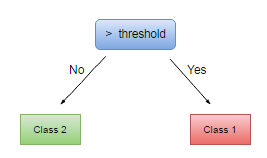

Классификатор работает следующим образом. На вход поступает одно число x, если x \* polarity >= threshold \* polarity, то классификатор возвращает 1, иначе 0. polarity равно либо 1 либо -1 и задает знак неравенства между threshold и x.

Чтобы обучить такой классификатор нам необходимо выбрать оптимальную точку разделения, минимизирующую количество мисклассификаций, взвешенных с помощью весов, полученных на очередном раунде бустинга

$$
\epsilon = \sum_i w_i |h_j(x_i) - y_i|
$$


Идея алгоритма следующая:

Пусть $w$ -- массив весов примеров, упорядоченных по значению признаков. Считаем, что все примеры имеют разное значение признака x. Если порог стоит в примере i, и polarity = 1, то функция потерь будет равна

$$
\epsilon = \sum_{j=1}^{i-1} w_j [y_j=1] + \sum_{j=i}^n w_j [y_j=0]
$$

[сумма весов всех примеров класса 1 строго слева от порога] + [сумма весов всех примеров класса 0 справа от порога(включая пример, в котором установлен порог)]

Допустим, мы знаем эти суммы (они называются кумулятивными), для всех возможных значений порога. Тогда, нужно просто сложить их и выбрать наименьшую.

Пример:

w = [2, 2, 2, 2, 2]

y = [0, 1, 0, 1, 1]

x = [1, 2, 3, 4, 5]

Если порог находится в x = 1

error = () + (2 + 2) т.к. слева от 1 нет ничего, а справа два неправильно классифицированных ноля веса 2

Сдвигаем порог вправо в x = 2

error = () + (2) т.к. слева нет единиц, а справа один ноль

Сдвигаем на x = 3

error = (2) + (2) т.к. слева одна единица, а справа один ноль

и т.д.

Можно в явном виде выписать все кумулятивные суммы

Сумма весов объектов класса один слева, если порог = x[i] 

s1 = [0, 0, 2, 2, 4]

Сумма весов объектов класса ноль справа, если порог = x[i] 

s2 = [4, 2, 2, 0, 0]

Заметим, что ошибка в позиции x[i] = s2[i] + s1[i] и оптимум лежит в позиции 2, с ошибкой = 2

Хотя второй вариант выглядит медленнее, он может быть эффективнее, если воспользоваться векторизованными примитивами numpy.  

Нужным примитивом является numpy.cumsum, реализуйте алгоритм с его помощью. Не забудьте, что нужно также посчитать оптимальный порог для polarity = -1

In [ ]:
class DecisionStump:
    def __init__(self, threshold = 0, polarity = 1):
        self.threshold = threshold
        self.polarity = polarity
        
    def train(self, X, y, w, indices):
        '''
            Функция осуществляет обучение слабого классификатора
            
            На входе:
                X -- одномерный отсортированный numpy массив со значениями признака
                y -- одномерный numpy массив со значением класса для примера (0|1)
                Порядок y -- до сортировки X
                w -- одномерный numpy массив со значением весов признаков
                Порядок w -- до сортировки X
                indices -- одномерный numpy массив, перестановка [несортированный X] -> [сортированный X]
                Массив indices нужен для оптимизации,
                чтобы не сортировать X каждый раз, мы предсортируем значения признаков
                для всех примеров. При этом мы сохраняем отображение между сортированными
                и изначальными индексами, чтобы знать соответствие между x, y и w

                indices[i] == изначальный индекс элемента, i-го в порядке сортировки
            
            На выходе:
            
            численное значение ошибки обученного классификатора
        '''
                
        w = np.take(w, indices)
        y = np.take(y, indices)
        
        #TODO
        l = list(map(get_error, [(X, w, y, 1), (X, w, y, -1)]))
        error, self.threshold, self.polarity = l[0] if l[0][0] < l[1][0] else l[1]
        return error
            
    def classify(self, x):
        #TODO
        return x * self.polarity >= self.threshold * self.polarity
    
    def __repr__(self):
        return "Threshold: {}, polarity: {}".format(self.threshold, self.polarity)

In [ ]:
def get_error(args):
    X, w, y, polarity = args
    if polarity == 1:
        s1 = np.concatenate((np.array([0]), np.cumsum(w * y)[:-1]))
        s2 = np.cumsum(w[::-1] * (1 - y)[::-1])[::-1]
        errors = s1 + s2
        i = np.argmin(errors)
        return errors[i], X[i], polarity
    else:
        s1 = np.concatenate((np.array([0]), np.cumsum(w * (1 - y))[:-1]))
        s2 = np.cumsum((w * y)[::-1])[::-1]
        errors = s1 + s2
        i = np.argmin(errors)
        return errors[i], X[i - 1], polarity

## Протестируем базовый классификатор

In [ ]:
classifier1 = DecisionStump(1, 1)

assert(classifier1.classify(1) == 1)
assert(classifier1.classify(10) == 1)
assert(classifier1.classify(0) == 0)
assert((classifier1.classify(np.array([1, 0, 10])) == np.array([1, 0, 1])).all())

In [ ]:
classifier = DecisionStump()
X = np.asarray([0, 1, 2, 3, 4])
y = np.asarray([0, 0, 1, 1, 1])
w = np.asarray([1, 1, 1, 1, 1])
error = classifier.train(X, y, w, [0, 1, 2, 3, 4])
assert(error == 0.0)
assert(classifier.threshold > 1 and classifier.threshold <= 2 and classifier.polarity == 1)

classifier = DecisionStump()
X = np.asarray([0, 1, 2, 3, 4])
y = np.asarray([0, 0, 1, 1, 1])
w = np.asarray([1, 1, 1, 1, 1])
error = classifier.train(X, y, w, [0, 1, 2, 3, 4])
assert(error == 0.0)
assert(classifier.threshold > 1 and classifier.threshold <= 2 and classifier.polarity == 1)

classifier = DecisionStump()
X = np.asarray([0, 1, 2, 3, 4])
y = np.asarray([1, 1, 0, 0, 0])
w = np.asarray([1, 1, 1, 1, 1])
error = classifier.train(X, y, w, [0, 1, 2, 3, 4])
assert(error == 0.0)
assert(classifier.threshold >= 1 and classifier.threshold < 2 and classifier.polarity == -1)

classifier = DecisionStump()
X = np.asarray([0, 1, 2, 3, 4])
y = np.asarray([0, 1, 0, 1, 1])
w = np.asarray([1, 1, 10, 1, 1])
error = classifier.train(X, y, w, [0, 1, 2, 3, 4])
assert(error == 1.0)
assert(classifier.threshold > 2 and classifier.threshold <= 3 and classifier.polarity == 1)

## Тренировка базового классификатора на всех признаках и выбор лучшего

Сейчас, когда мы умеем тренировать слабый классификатор, необходимо найти лучший слабый классификатор по всем признакам. 

In [ ]:
def train_classifier(classifier_type, X, y, w, indices):
    classifier = classifier_type()
    error = classifier.train(X, y, w, indices)
    return error, classifier

def learn_best_classifier(classifier_type, X, y, w, indices):
    '''
    Функция находит лучший слабый классификатор
    
    На входе:
        classifier_type -- класс классификатора (DecisionStump в нашем случае)
        X -- двумерный numpy массив, где X[i, j] -- значение признака i для примера j
        Каждый X[i] отсортирован по возрастанию
        y -- одномерный numpy массив с классом объекта (0|1). Порядок y соответствует порядку примеров в датасете
        w -- одномерный numpy массив весов для каждого примера. Порядок w соответствует порядку примеров в датасете
        indices -- список одномерных numpy массивов. 
        indices[i, j] == изначальный индекс элемента, j-го в порядке сортировки для i-го признака
        
    На выходе:
        best_classifier -- лучший слабый классификатор
        best_error -- его ошибка
        best_feature_ind -- номер признака, на котором он был обучен (одна из HaarFeatures)
        predictions -- предсказания классификатора (в порядке до сортировки)
    '''
    best_error = 1e10
    best_classifier = None
    best_feature_ind = None

    features_count = X.shape[1]
    errors = np.zeros(features_count)
    classifiers = [None] * features_count
    
    #TODO
    # натренируем каждый классификатор по каждому признаку
    for i in range(0, features_count):
        errors[i], classifiers[i] = train_classifier(classifier_type, X[i], y, w, indices[i])
        if errors[i] < best_error:
            best_error = errors[i]
            best_classifier = classifiers[i]
            best_feature_ind = i
    

    # выберем наилучший и сохраним лучший классификатор, ошибку, признак и индекс признака в 
    # best_classifier, best_error, best_feature, best_feature_ind   
    return best_classifier, best_error, best_feature_ind